In [124]:
# Pre-requisites
import numpy as np

# For plots
%matplotlib inline
import matplotlib.pyplot as plt

# To clear print buffer
from IPython.display import clear_output

# Importing functions from the previous tutorials:

In [60]:
# Initializing weight matrices from layer sizes
def initializeWeights(layers):
    weights = [np.random.randn(o, i+1) for i, o in zip(layers[:-1], layers[1:])]
    return weights

# Add a bias term to every data point in the input
def addBiasTerms(X):
        # Make the input an np.array()
        X = np.array(X)
        
        # Forcing 1D vectors to be 2D matrices of 1xlength dimensions
        if X.ndim==1:
            X = np.reshape(X, (1, len(X)))
        
        # Inserting bias terms
        X = np.insert(X, 0, 1, axis=1)
        
        return X

# Sigmoid function
def sigmoid(a):
    return 1/(1 + np.exp(-a))

# Forward Propagation of outputs
def forwardProp(X, weights):
    # Initializing an empty list of outputs
    outputs = []
    
    # Assigning a name to reuse as inputs
    inputs = X
    
    # For each layer
    for w in weights:
        # Add bias term to input
        inputs = addBiasTerms(inputs)
        
        # Y = Sigmoid ( X .* W^T )
        outputs.append(sigmoid(np.dot(inputs, w.T)))
        
        # Input of next layer is output of this layer
        inputs = outputs[-1]
        
    return outputs

# Compute COST (J) of Neural Network
def nnCost(weights, X, Y):
    # Calculate yPred
    yPred = forwardProp(X, weights)[-1]
    
    # Compute J
    J = 0.5*np.sum((yPred-Y)**2)/len(Y)
    
    return J

# IMPLEMENTING BACK-PROPAGATION WITH LEARNING RATE
# Added eta, the learning rate, as an input
def backProp(weights, X, Y, learningRate):
    # Forward propagate to find outputs
    outputs = forwardProp(X, weights)
    
    # For the last layer, bpError = error = yPred - Y
    bpError = outputs[-1] - Y
    
    # Back-propagating from the last layer to the first
    for l, w in enumerate(reversed(weights)):
        
        # Find yPred for this layer
        yPred = outputs[-l-1]
        
        # Calculate delta for this layer using bpError from next layer
        delta = np.multiply(np.multiply(bpError, yPred), 1-yPred)
        
        # Find input to the layer, by adding bias to the output of the previous layer
        # Take care, l goes from 0 to 1, while the weights are in reverse order
        if l==len(weights)-1: # If 1st layer has been reached
            xL = addBiasTerms(X)
        else:
            xL = addBiasTerms(outputs[-l-2])
        
        # Calculate deltaW for this layer
        deltaW = -np.dot(delta.T, xL)/len(Y)
        
        # Calculate bpError for previous layer to be back-propagated
        bpError = np.dot(delta, w)
        
        # Ignore bias term in bpError
        bpError = bpError[:,1:]
        
        # Change weights of the current layer (W <- W + eta*deltaW)
        w += learningRate*deltaW

# A function to check accuracy
def accuracy(weights, X, Y):
    yPred = forwardProp(X, weights)[-1]
    return np.sum([np.all(int(yPred[i]>0.5)==Y[i]) for i in range(len(Y))])/float(len(Y))

# Initialize network
layers = [2, 2, 1]
weights = initializeWeights(layers)

print("weights:")
for i in range(len(weights)):
    print(i+1); print(weights[i].shape); print(weights[i])

# Declare input and desired output for AND gate
X = np.array([[0,0], [0,1], [1,0], [1,1]])
Y = np.array([[0], [0], [0], [1]])

weights:
1
(2, 3)
[[ 0.4589191  -0.80342909  0.63829477]
 [-0.822853    0.21377034 -0.43877021]]
2
(1, 3)
[[ 0.44410521 -0.90797909 -1.09305866]]


# Batch Gradient Descent

Batch Gradient Descent is how we have tried to train our network so far - give it ALL the data points, compute ${\Delta}W$s by summing up quantities across ALL the data points, change all the weights once, Repeat.

Suppose we want to train our 3-neuron network to implement Logical XOR.

Inputs are: $X=\left[\begin{array}{c}(0,0)\\(0,1)\\(1,0)\\(1,1)\end{array}\right]$, and the desired output is $Y=\left[\begin{array}{c}0\\1\\1\\0\end{array}\right]$.

In [61]:
# Initialize network
layers = [2, 2, 1]
weights = initializeWeights(layers)

print("weights:")
for i in range(len(weights)):
    print(i+1); print(weights[i].shape); print(weights[i])

# Take backup of weights to be used later for comparison
initialWeights = [np.array(w) for w in weights]

weights:
1
(2, 3)
[[-0.89281994  1.85819772 -0.67892636]
 [ 0.2452601   0.5661631  -0.50233833]]
2
(1, 3)
[[-0.36897464  1.21082044  0.36616429]]


In [62]:
# Declare input and desired output for AND gate
X = np.array([[0,0], [0,1], [1,0], [1,1]])
Y = np.array([[0], [1], [1], [0]])

In [63]:
# Check current accuracy and cost
print("Cost: "+str(nnCost(weights, X, Y)))
print("Accuracy: "+str(accuracy(weights, X, Y)))

Cost: 0.131007959716
Accuracy: 0.25


We know that in order to train the network, we need to call backProp repeatedly. Let us use a function to do that.

In [64]:
# TRAINING FUNCTION, USING GD
def train(weights, X, Y, nIterations, learningRate=1):
    for i in range(nIterations):
        clear_output()
        print("Iteration "+str(i+1)+" of "+str(nIterations))

        # Run backprop
        backProp(weights, X, Y, learningRate)

        print("Cost: "+str(nnCost(weights, X, Y)))
        print("Accuracy: "+str(accuracy(weights, X, Y)))

Say we want to train our model 100 times.

In [66]:
nIterations = 600
train(weights, X, Y, nIterations)

Iteration 600 of 600
Cost: 0.0608623845375
Accuracy: 1.0


In [68]:
forwardProp(X, weights)[-1]

array([[ 0.3349436 ],
       [ 0.50743917],
       [ 0.79439871],
       [ 0.29970618]])

It took our function a long time to train.

What if we speed up using adaptive learning rate?

In [69]:
# TRAINING FUNCTION, USING GD
# Default learning rate = 1.0
def trainUsingGD(weights, X, Y, nIterations, learningRate=1.0):
    # Setting initial cost to infinity
    prevCost = np.inf
    
    # For nIterations number of iterations:
    for i in range(nIterations):
        clear_output()
        print("Iteration "+str(i+1)+" of "+str(nIterations))

        # Run backprop
        backProp(weights, X, Y, learningRate)
        
        cost = nnCost(weights, X, Y)
        print("Cost: "+str(cost))
        print("Accuracy: "+str(accuracy(weights, X, Y)))
        
        # ADAPT LEARNING RATE
        # If cost increases
        if (cost > prevCost):
            # Halve the learning rate
            learningRate /= 2.0
        # If cost decreases
        else:
            # Increase learning rate by 5%
            learningRate *= 1.05
        
        prevCost = cost

In [117]:
# Revert weights back to initial values
weights = [np.array(w) for w in initialWeights]

In [118]:
# Train for nIterations
# Don't expect same results for running with 20 iterations
# as with running twice with 10 iterations - learning rates are different!
nIterations = 78
trainUsingGD(weights, X, Y, nIterations)

Iteration 78 of 78
Cost: 0.0495853780854
Accuracy: 1.0


We see that with adaptive learning rate, we reach the desired output much faster!

# MNIST Dataset

MNIST is a dataset of 60000 images of hand-written numbers.

In [185]:
# Load MNIST DATA
# Use numpy.load() to load the .npz file
f = np.load('mnist.npz')
# Saving the files
x_train = f['x_train']
y_train = f['y_train']
x_test = f['x_test']
y_test = f['y_test']
f.close()

x_train.shape = (60000, 28, 28)
y_train.shape = (60000,)


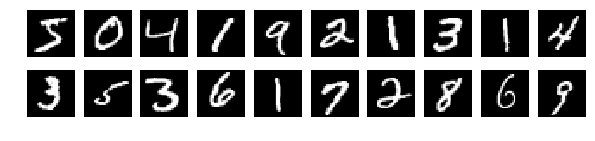

In [186]:
# To check MNIST data
print("x_train.shape = "+str(x_train.shape))
print("y_train.shape = "+str(y_train.shape))
fig = plt.figure(figsize=(10, 2))
for i in range(20):
    ax1 = fig.add_subplot(2, 10, i+1)
    ax1.imshow(x_train[i], cmap='gray');
    ax1.axis('off')

(In supervised learning) Every (good) dataset consists of a training set and a test set.

The training data set consists of data points and their desired outputs.

In this case, the data points are grayscale images of hand-written numbers, and their desired outputs are the numbers that have been drawn.

The test data set consists of data points whose outputs need to be found.

Let us implement the following neural network to classify MNIST data:
<center>![MNIST NN](images/digitsNN.png)

## Inintialize network

MNIST dataset has images of size 28x28. So the input layer to our network must have $28*28=784$ neurons.

Since we are tring to classify whether the image is that of 0 or 1 or 2 ... or 9, we need to have 10 output neurons, each catering to the probability of one number among 0-9.

Let our hidden layer (as shown in the diagram) have 15 neurons.

In [187]:
# Initialize network
layers = [784, 15, 10]
weights = initializeWeights(layers)

# Take backup of weights to be used later for comparison
initialWeights = [np.array(w) for w in weights]

In [188]:
# Please don't print the weights
# There are 15*784=11760 weights in the first layer,
# + 10*10=150 weights in the second layer
'''
print("weights:")
for i in range(len(weights)):
    print(i+1); print(weights[i].shape); print(weights[i])
'''


'\nprint("weights:")\nfor i in range(len(weights)):\n    print(i+1); print(weights[i].shape); print(weights[i])\n'

## Are our inputs in the right format and shape?

Remember that we give inputs as np.arrays of $n{\times}784$ dimensions, $n$ being the number of data points we want to input to the network.

Is ``x_train`` an np.array?

In [189]:
# Check type of x_train
type(x_train)

numpy.ndarray

Yup, ``x_train`` is an np.array

Is ``x_train`` in the shape required by the network?

In [190]:
# Check shape of x_train
x_train.shape

(60000, 28, 28)

Clearly not.

We need to reshape this matrix to $60000{\times}784$.

In [191]:
# Reshaping x_train for our network with 784 inputs neurons
x_train = np.reshape(x_train, (len(x_train), 784))

# Check the dimensions
x_train.shape

(60000, 784)

Now our input is in the right format and shape.

## Are our inputs normalized?

Remember that we had decided to limit the range of values for the input to 0-1.

Are all the values of ``x_train`` between 0 and 1?

In [192]:
# Check range of values of x_train
print("Values in x_train lie between "+str(np.min(x_train))+" and "+str(np.max(np.max(x_train))))

Values in x_train lie between 0 and 255


Our inputs are images, their values range from 0 to 255. We need to bring them down to 0-1.

In [193]:
# Normalize x_train
x_train = x_train / 255.0

In [194]:
# Check range of values of x_train
print("Values in x_train lie between "+str(np.min(x_train))+" and "+str(np.max(np.max(x_train))))

Values in x_train lie between 0.0 and 1.0


Perfect.

## Are our outputs in the right format and shape?

Is ``y_train`` an np.array?

In [195]:
# Check type of y_train
type(y_train)

numpy.ndarray

Yup, ``y_train`` is an np.array

Remember that we have 10 neurons in the output layer. That means our output needs to be of ${n{\times}10}$ dimensions.

Is the shape of ``y_train`` $n{\times}10$?

In [196]:
# Check shape of y_train
y_train.shape

(60000,)

Nope, ``y_train`` is of shape $60000{\times}1$

What are its values like?

In [197]:
for i in range(5):
    print(y_train[i])

5
0
4
1
9


So ``y_train`` carries the numbers of the digits the images represent.

We need to make a new binary array of $60000{\times}10$ and insert a 1 in the column corresponding to the number of the digit its image shows.

For example, the first row of our new y_train should look like $\left[\begin{array}{c}0&0&0&0&0&1&0&0&0&0\end{array}\right]$, since it represents 5. This is called one-hot encoding.

In [198]:
# Make new y_train of nx10 elements
new_y_train = np.zeros((len(y_train), 10))
for i in range(len(y_train)):
    new_y_train[i, y_train[i]] = 1

In [199]:
# Check first row of y_train
print(new_y_train[0])

[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


Now that new_y_train is correctly shaped and formatted, let us reassign the name y_train to the matrix new_y_train.

In [201]:
# Reassign the name "y_train" to new_y_train
y_train = new_y_train

# Stochastic Gradient Descent

In [128]:
15*784

11760